### Arima modeling a day of packets & EDA

##### Shane Caldwell

(A hot day in late July)

Packets dropped that were coming from a destination in China were put into 10 minutes intervals and displayed as follows. 

First, we'll do a little cleaning.

In [9]:
import csv
import pandas as pd

with open('../data/one_day.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    cleaned = []
    next(reader)
    for row in reader:
        timestamp = row[0]
        count = row[3]
        timestamp = timestamp.replace("(", "")
        cleaned.append([timestamp, count])

with open('../data/one_day_cleaned.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['timestamp', 'dropped'])
    for row in cleaned:
        writer.writerow(row)

In [10]:
df = pd.read_csv('../data/one_day_cleaned.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values(by='timestamp')
df.timestamp = pd.to_datetime(df.timestamp)
#df.index= pd.to_datetime(df.timestamp)
#df.drop(['timestamp'], axis=1, inplace=True)

The timestamps arrive as a unixstamp, which is the 'current unix timestamp'. This is the raw number of seconds Jan 01 1970 (the beginning of the epoch). It's in UTC, or "coordinated universal time". 

UTC is great for computers, but we'd like to be able to look at this from the perspective of China, so let's shift the timestamp to China time!

In most other countries, this would be impossible. China is big - and has several timezones. Right? WRONG. 

China is geographically large enough for 5 timezones, but they all operate off of "China Standard Time" which is Beijing time. The communist party put this forward in 1949 for the purpose of national unity. It's 8 hours ahead of UTC. 

Quora suggests the workweek is essentially the same as in the US, so 9-6 or so is standard.
https://www.quora.com/What-is-the-normal-work-week-in-China-Do-the-Chinese-then-party-down-on-Friday-Saturday-night

In [11]:
from dateutil import tz
from datetime import datetime

def convert_to_chinatime(x):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Shanghai')
    x = x.replace(tzinfo=from_zone)
    china = x.astimezone(to_zone)
    return china

df.timestamp = df.timestamp.apply(convert_to_chinatime)
df.index= pd.to_datetime(df.timestamp)
df.drop(['timestamp'], axis=1, inplace=True)

What does that look like? 

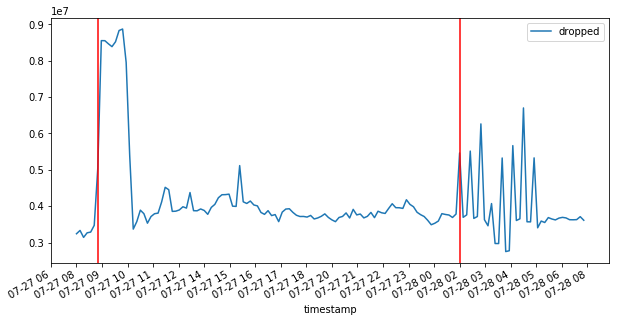

In [12]:
#import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5] # figures are too small in these notebooks


fig, ax = plt.subplots()
ax = df.plot(ax = ax)
#plt.xticks(xi, df.index)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
plt.axvline(x='2016-07-27 09:00:00+08:00', label='Work', c='red')
plt.axvline(x='2016-07-28 02:00:00+08:00', label='Work', c='red')
plt.show()


Is the data stationary? It doesn't necessarily look like it, but let's use the Augmented Dickey-Fuller test to confirm. 

In [5]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

dropped = df['dropped']
print('---------- Augmented Dickey-Fuller(pre-difference) ---------')
result = adfuller(dropped)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
print('--------------------------------------------')

---------- Augmented Dickey-Fuller(pre-difference) ---------
ADF Statistic: -5.460954
p-value: 0.000003
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579
--------------------------------------------


We run the Augmented Dickey-Fuller test and fail to reject the null hypothesis that the time series has a unit root. This means it is non-stationary. Let's take the difference and see what that looks like. 

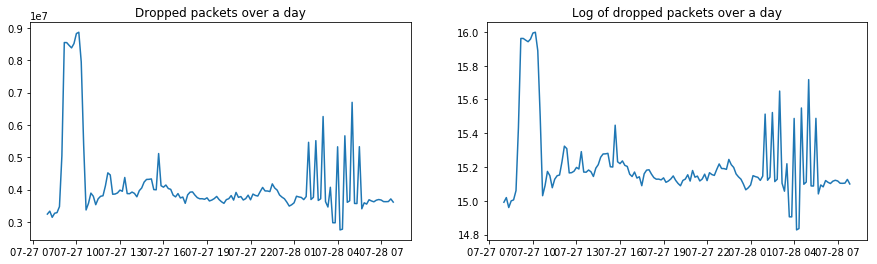

In [6]:
### Take log
import numpy as np
import matplotlib.pyplot as plt

df['ln_dropped'] = np.log(df['dropped'])

# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
# Levels
axes[0].plot(df.index._mpl_repr(), df['dropped'], '-')
axes[0].set(title='Dropped packets over a day')
# Log difference
axes[1].plot(df.index._mpl_repr(), df['ln_dropped'], '-')
axes[1].set(title='Log of dropped packets over a day');
plt.show()

In [7]:
import pyramid as pm
arima = pm.auto_arima(df['dropped'], error_action='ignore', trace=1, seasonal=True, m=12)

#Fit ARIMA: order=(4, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=4257.252, BIC=4277.992, Fit time=0.177 seconds

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=4270.152, BIC=4293.855, Fit time=2.107 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=4322.347, BIC=4328.272, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=4304.339, BIC=4316.190, Fit time=0.069 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=4300.061, BIC=4311.913, Fit time=0.127 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=4268.386, BIC=4289.126, Fit time=1.301 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=4272.903, BIC=4290.680, Fit time=0.229 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=4271.914, BIC=4298.580, Fit time=2.688 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=4285.364, BIC=4303.141, Fit time=0.330 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=4261.773, BIC=4285.476, Fit time=0.986 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=4257.965, BIC=4278.705, Fit time=0.253 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=4291.240, BIC=4306.054, Fit time=0.106 seconds


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=4263.596, BIC=4290.262, Fit time=1.706 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=4259.387, BIC=4283.090, Fit time=0.467 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=4268.492, BIC=4286.269, Fit time=0.075 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=4261.777, BIC=4288.443, Fit time=1.558 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=4259.213, BIC=4282.916, Fit time=0.338 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=4256.502, BIC=4274.279, Fit time=0.142 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=4258.205, BIC=4278.945, Fit time=0.351 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 